In [1]:
import pandas as pd
import numpy as np
import folium
import requests 
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('Toronto2.csv')
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892


In [3]:
address = 'Toronto, Ontario Canada'
geolocator = Nominatim(user_agent="Your_app-name")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)
map_toronto

### Filtering out Borough having 'Toronto' in it.

In [4]:
df = df[df['Borough'].str.contains("Toronto")].reset_index(drop=True)
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.67709,-79.29547
1,M4K,East Toronto,"The Danforth West, Riverdale",43.68375,-79.35512
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.66797,-79.31467
3,M4M,East Toronto,Studio District,43.66213,-79.33497
4,M4N,Central Toronto,Lawrence Park,43.72843,-79.38713


In [5]:
df.shape

(39, 5)

In [6]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5, popup=label, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7,parse_html=False).add_to(map_toronto)  
map_toronto

### Foursquare API

In [7]:
CLIENT_ID = '4JYGPYVZM3FFHE4RJDUL2PPCNPVUVVMYINQ20AZXGSSMGIRA'
CLIENT_SECRET = 'L1ZGIOW4K5D33NVCXLOONAEG3PNCPLDC1ZURXB0UB4SWBMOA'
VERSION = '20201216'
LIMIT = 30

In [8]:
def nearbyplaces(names, latitudes, longitudes, radius=500):
    places_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        places_list.append([( name, lat, lng, p['venue']['name'], p['venue']['location']['lat'], p['venue']['location']['lng'], p['venue']['categories'][0]['name']) for p in results])
    nearby_places = pd.DataFrame([item for places_list in places_list for item in places_list])
    nearby_places.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Place', 'Place Latitude', 'Place Longitude', 'Place Category']
    return(nearby_places)
toronto_places = nearbyplaces(names=df['Neighbourhood'], latitudes=df['Latitude'],longitudes=df['Longitude'])

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

In [9]:
toronto_places.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Place,Place Latitude,Place Longitude,Place Category
0,The Beaches,43.67709,-79.29547,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.67709,-79.29547,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.67709,-79.29547,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.67709,-79.29547,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.68375,-79.35512,Centennial College - Story Arts Centre,43.684874,-79.349140,Business Service


In [10]:
print('There are {} uniques categories.'.format(len(toronto_places['Place Category'].unique())))

There are 178 uniques categories.


In [11]:
toronto_places.shape

(806, 7)

In [12]:
toronto_places['Place Category'].value_counts().head()

Coffee Shop    66
Café           53
Restaurant     32
Park           25
Bakery         24
Name: Place Category, dtype: int64

In [13]:
new_df = pd.get_dummies(toronto_places['Place Category'], prefix="", prefix_sep="")

In [14]:
new_df = pd.concat([new_df, toronto_places['Neighbourhood']], axis = 1)

In [15]:
new_df.head()

,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Noodle House,Opera House,Organic Grocery,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,The Beaches
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [16]:
new_df = new_df.groupby('Neighbourhood').mean().reset_index()
new_df.head()

,Neighbourhood,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Noodle House,Opera House,Organic Grocery,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.000000,0.0,0.0,0.033333,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.066667,0.0,0.0,0.0,0.033333,0.000000,0.0,0.000000,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.033333,0.000000,0.066667,0.066667,0.0,0.0,0.033333,0.000000,0.033333,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.066667,0.000000,0.0,0.033333,0.0,0.0,0.000000,0.0,0.033333,0.033333,0.033333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.033333,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.000000,0.000000,0.066667,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.033333,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.0,0.000000,0.000000,0.033333,0.000000,0.0,0.0,0.0,0.066667,0.0,0.033333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.000000,0.000000,0.033333,0.066667,0.0,0.0,0.000000,0.000000,0.000000

In [17]:
new_df.shape

(38, 179)

### Clustering

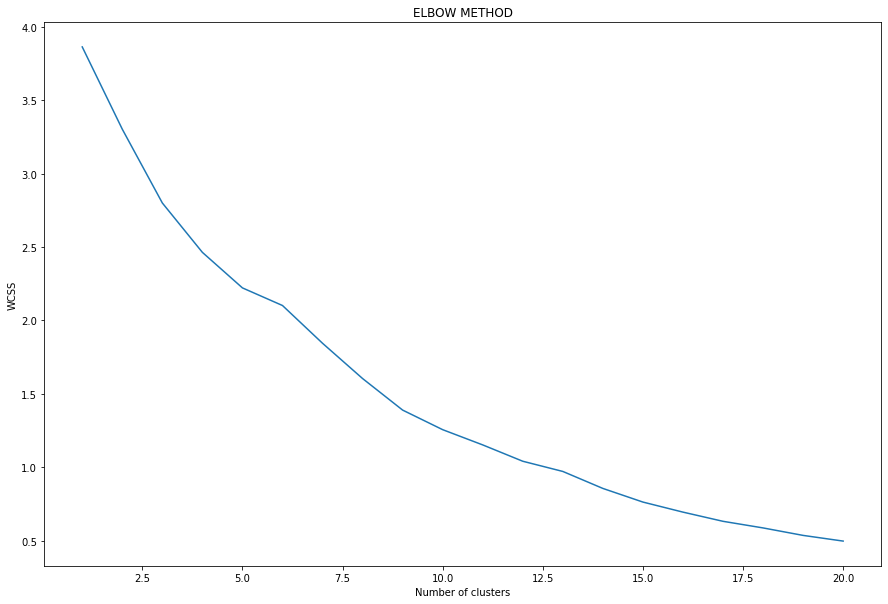

In [18]:
plt.figure(figsize=(15,10))
X = new_df.drop('Neighbourhood', axis = 1).values
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, random_state = 17)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 21), wcss)
plt.title('ELBOW METHOD')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Taking k = 9

In [21]:
kmc = KMeans(n_clusters = 9)
kmc.fit_predict(X)
new_df['Cluster'] = pd.Series(kmc.labels_)
new_df.head()

,Neighbourhood,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Noodle House,Opera House,Organic Grocery,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio,Cluster
0,Berczy Park,0.000000,0.0,0.0,0.033333,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.066667,0.0,0.0,0.0,0.033333,0.000000,0.0,0.000000,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.033333,0.000000,0.066667,0.066667,0.0,0.0,0.033333,0.000000,0.033333,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.066667,0.000000,0.0,0.033333,0.0,0.0,0.000000,0.0,0.033333,0.033333,0.033333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.033333,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.000000,0.000000,0.066667,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.033333,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.000000,0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.0,0.000000,0.000000,0.033333,0.000000,0.0,0.0,0.0,0.066667,0.0,0.033333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.000000,0.000000,0.033333,0.066667,0.0,0.0,0.000000,0.00000

In [37]:
df['Cluster'] = new_df['Cluster']

In [38]:
df.drop(df.tail(1).index,inplace=True)
df['Cluster'] = df['Cluster'].astype(int)
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster
0,M4E,East Toronto,The Beaches,43.67709,-79.29547,0
1,M4K,East Toronto,"The Danforth West, Riverdale",43.68375,-79.35512,4
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.66797,-79.31467,4
3,M4M,East Toronto,Studio District,43.66213,-79.33497,0
4,M4N,Central Toronto,Lawrence Park,43.72843,-79.38713,0


In [39]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
x = np.arange(9)
ys = [i+x+(i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighbourhood'], df['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(map_clusters)
map_clusters